## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#No. of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#Unique users in the dataset
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
#porportion of users converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#Total no. of times new page ad treatment do not match
mismatch_df = df.query("(group == 'treatment' and landing_page == 'old_page') or (group == 'control' and landing_page == 'new_page') ")
mismatch_df.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
#Checking if there are null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no null values in the dataframe.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Drop the mis-matched rows
df2 = df.drop(mismatch_df.index)
#View the dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#No. of unique users
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#Duplicate users
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
#Row info of the duplicated row
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#Drop the duplicated row
df2.drop(2893,inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#Probability of an individual converting
converted_prob = df2.converted.mean()
converted_prob

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#Control group individual converting
control_convert = df2.query("group == 'control' ")['converted'].mean()
control_convert

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#Treatment group individual converting
treatment_convert = df2.query("group == 'treatment' ")['converted'].mean()
treatment_convert

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
#Porbability of individual recieving new page 
prob_new_page = (df2['landing_page'] == 'new_page').mean()
prob_new_page

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:** From the above stats, it just seems that the probability for an individual who received the control page is more than that of the treatment page.But , there is not much evidence to prove if it is right or not.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null Hypothesis : 
If p-value is less than 5%, the old page has a higher chance of converting users.
#### Alternative Hypothesis:
If p-value is greater than or equal to 5%, then the new page has a higher chance of converting users.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
#Conversion rate for p_new
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
#Conversion rate for p_old
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
#No. of individuals in the treatment group
n_new = df2.landing_page.value_counts()[0]
n_new

145310

In [21]:
df2.landing_page.value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
#No. of individuals in the control group
n_old = df2.landing_page.value_counts()[1]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#Random simulation of new page landings
new_page_converted = np.random.choice(2,size = n_new, p=[p_new,1-p_new])
new_page_converted.mean()

0.88105429770834764

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#Random simulation of old page landings
old_page_converted = np.random.choice(2,size = n_old,p=[p_old,1-p_old])
old_page_converted.mean()

0.88090780180899542

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.00014649589935222807

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
#Calculate p_diffs
p_diffs,bs_new_means,bs_old_means = [],[],[]

for _ in range(10000):
    bs_new = np.random.choice(2,size=n_new,p=[p_new,1-p_new])
    bs_old = np.random.choice(2,size=n_old,p=[p_old,1-p_old])
    bs_new_means.append(bs_new.mean())
    bs_old_means.append(bs_old.mean())
    p_diffs.append(bs_new.mean() - bs_old.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

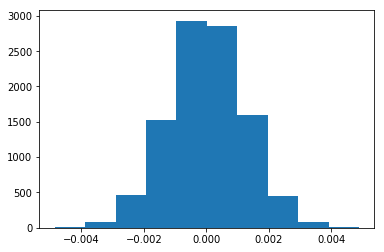

In [27]:
#Convert the p_diffs into np array
p_diffs = np.array(p_diffs)
#plot the histogram of p_diffs
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
actual_diff = df2.query(" landing_page == 'new_page' ").converted.mean() - df2.query("landing_page == 'old_page'").converted.mean()
actual_diff

-0.0015782389853555567

In [29]:
(p_diffs > actual_diff).mean()

0.90749999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** We have computed actual vs difference of meanns of converted old page and converted new page.We had random choices of these mean converted values for the observed difference.These are stored in p_diffs.This value is the p-value .Our p-value exceeds the critical value of 0.05 in this case and so we fail to reject the null hypothesis; we cannot assume the new page converts more users than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == '1'").count()[0]
convert_new = df2.query("landing_page == 'new_page' and converted == '1'").count()[0]
n_old = df2.landing_page.value_counts()[1]
n_new = df2.landing_page.value_counts()[0]

convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
#Calculate x-value and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [32]:
from scipy.stats import norm

norm.cdf(z_score)

0.90505831275902449

In [33]:
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** The z-score of 1.311 is less than the critical value at 95% confidence interval, 1.96. So, it falls within the confidence interval range of 95%. We fail to reject the null hypothesis.The old page coverted more users than new page. Our p-value of 0.189 is different than what we computed in parts j and k(0.898) which is expected because the null and alternative hypothesis assumed that the p_new and p_old are the same and that there is no difference in converting users from the old page and new page. However, that is not the case since the old page does convert more users than the old page based on the lower p-value(0.189).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** For this problem, it is better to use Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:
#Get dummy variables
df2[['ab_page', 'treatment']] = pd.get_dummies(df2['group'])

#Drop columns
df2 = df2.drop(['treatment','group'],1)

df2['intercept'] =1
df2.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
#Instatiation of th regression model
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = log_mod.fit()

# To rectify this error "AttributeError: module 'scipy.stats' has no attribute 'chisqprob'"
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        03:16:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

In [38]:
np.exp(0.0150)

1.0151130646157189

In [39]:
1/np.exp(0.0150)

0.98511193960306276

The p-value (0.190) here remains above an $\alpha$ level of 0.05 but is different because this is a two tailed test. We will still reject the null in this situation.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:** The p-value found in the logistic regression model(0.19) is different than what we found in parts j and k because our null and alternative hypthesis model assumed that there is an equal probability of the old and new page converting users. In the logistic regression model, this is not the case. Also, the Logistic Regression performed is a two-tailed test, whereas the computation done in Part II is a one-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** Other factors that influence whether an individual converts could be age. Older users may prefer more information on the pages as opposed to a kid, where they may prefer more pictures and a more casual theme. Adding more factors into the regression model will increase or decrease confidence intervals. A disadvantage of multiple factors in a logistic regression model is that it reduces the power of analysis.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
df_countries = pd.read_csv("countries.csv")
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
df_merge = df2.join(df_countries.set_index('user_id'), on='user_id')
df_merge.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,1,US
2,661590,2017-01-11 16:55:06.154213,new_page,0,0,1,US
3,853541,2017-01-08 18:28:03.143765,new_page,0,0,1,US
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,1,US


In [42]:
df_merge.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
df_merge[['US','UK','CA']] = pd.get_dummies(df_merge['country'])
df_merge = df_merge.drop(['country','CA'],axis = 1)

df_merge.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept,US,UK
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,new_page,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,1,0,0


In [44]:
df_merge['intercept'] = 1

logit_mod = sm.Logit(df_merge['converted'],df_merge[['intercept','US','UK']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [45]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        03:16:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**From the above summary, none of the p-values are significant and therefore we do ot have evidence that these countries differ in terms of conversions. We also do not have the evidence that the page a user receives influences their rate of conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
df_merge['US_ab_page'] = df_merge['US'] * df_merge['ab_page']
df_merge['UK_ab_page'] = df_merge['UK'] * df_merge['ab_page']

In [47]:
df_merge['intercept'] = 1

logit_mod = sm.Logit(df_merge['converted'],df_merge[['intercept','ab_page','US','UK','US_ab_page','UK_ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        03:16:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0070      0.010   -207.045      0.000      -2.026      -1.988
ab_page        0.0206      0.014      1.505      0.132      -0.006       0.047
US            -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK             0.0257      0.019      1.363      0.173      -0.011       0.063
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

**By looking at the stats, it does not seem like we have proper information to conclude with a decision as the p-values do not significant values.Therefore, we fail to reject the null hypothesis.**

<a id='conclusions'></a>
## Conclusion


From the observations made above, there is no sufficient information about the conversion rates for new and old page.We fail to reject the null hypothesis.

The p-values for countries are well above 0.05 alpha level. We fail to reject the null hypothesis and there is no significant contribution to differences in conversion rates for the two pages. 

In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0